# Sheet 10

## 1 Optimal Transport

In [9]:
import numpy as np

d = 5
num_sources = 10
num_sinks = 20

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

In [10]:
# TODO: solve the OT problem as linear program
from scipy.optimize import linprog

def solve_optimal_transport(supply, demand, coords_supply, coords_demand):

    # Define the cost matrix
    cost_matrix = np.linalg.norm(coords_supply[:, None, :] - coords_demand[None, :, :], axis=2)
    
    # Flatten the cost matrix
    cost_matrix_flat = cost_matrix.flatten()

    # Create constraint matrix A_eq and vector b_eq
    A_eq = []
    b_eq = []

    # Supply constraints: sum_j T[i, j] = supply[i]
    for i in range(num_sources):
        row = [1 if k // num_sinks == i else 0 for k in range(num_sources * num_sinks)]
        A_eq.append(row)
        b_eq.append(supply[i])

    # Demand constraints: sum_i T[i, j] = demand[j]
    for j in range(num_sinks):
        row = [1 if k % num_sinks == j else 0 for k in range(num_sources * num_sinks)]
        A_eq.append(row)
        b_eq.append(demand[j])

    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)

    # Bounds: T[i, j] >= 0 for all i, j
    bounds = [(0, None) for _ in range(num_sources * num_sinks)]

    # Solve the linear program
    result = linprog(cost_matrix_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    # Reshape the transport plan to the original source-sink matrix shape
    transport_plan = result.x.reshape(num_sources, num_sinks)
    total_cost = result.fun

    return transport_plan, total_cost



# Solve the problem
transport_plan, total_cost = solve_optimal_transport(mass_sources, mass_sinks, coords_sources, coords_sinks)

print("Optimal Transport Plan:")
print(transport_plan)
print("Total Transportation Cost:")
print(total_cost)



Optimal Transport Plan:
[[0.         0.         0.0305051  0.         0.02285223 0.
  0.         0.         0.         0.         0.01865067 0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.02796887 0.         0.         0.
  0.         0.06595275 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.03463926
  0.05422072 0.        ]
 [0.         0.12190079 0.01299226 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00583801]
 [0.         0.         0.00316162 0.         0.         0.01188377
  0.03823796 0.         0.         0.         0.         0.
  0.0367175  0.         0.         0.         0.02509552 0.
  0.         0.        ]
 [0.         0.         0.0299957  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.     

## 2 Flow matching for generative modeling

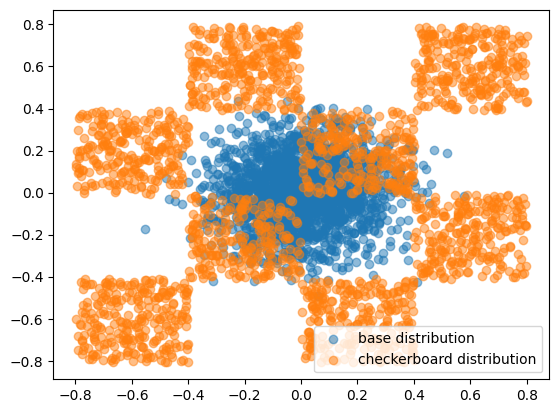

In [13]:
import torch
import matplotlib.pyplot as plt

def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x
    
base_distribution_std = 0.15
num_samples = 2000
x = torch.randn(num_samples, 2) * base_distribution_std
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.legend()
plt.show()

100%|██████████| 10000/10000 [23:14<00:00,  7.17it/s]


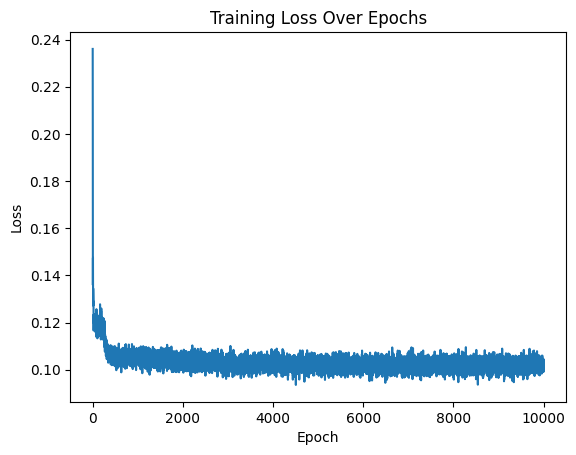

In [14]:
# define a model
import numpy as np
from torchvision.ops import MLP
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLP(in_channels=2 + 1, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)

# define a loss function
criterion = torch.nn.MSELoss(reduction="none")

# define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# train the model:
num_epochs = 10000  # use fewer epochs if it takes too long
batch_size = 4096
losses = []

for epoch in tqdm(range(num_epochs)):

    x = torch.randn(batch_size, 2) * base_distribution_std
    y = generate_checkerboard_sample(num_samples=batch_size)

    """
    We want the model to predict the velocity field that transports points from a initial distribution x to a final distribution y.
    For that, both spatial (the coordinates of a moving point) and temporal (the moment the coordinates were "measured") information are needed.
    """

    # We get the temporal information from random time points sampled uniformly in [0, 1].
    t = torch.rand(batch_size, device=device).unsqueeze(-1)  

    # And the spatial information interpolating points between base (x) and target (y) distributions using the generated times.
    psi_t = (1 - t) * x + t * y 

    # We concatenate both tensors in a single one and feed it to the model to predict the velocity field.
    predicted_velocity = model(torch.cat([psi_t, t], dim=-1)) 

    # The ideal movement of every point should be a straight line from its origin towards its destiny, so we can use the assume the true velocity field to be given by:
    delta_x = y - x 

    # Compute the loss 
    loss = criterion(predicted_velocity, delta_x).mean()

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss for analysis
    losses.append(loss.item())

# Plot the loss
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

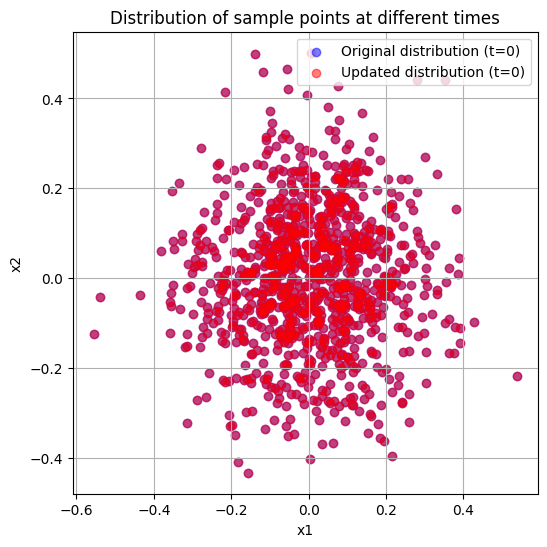

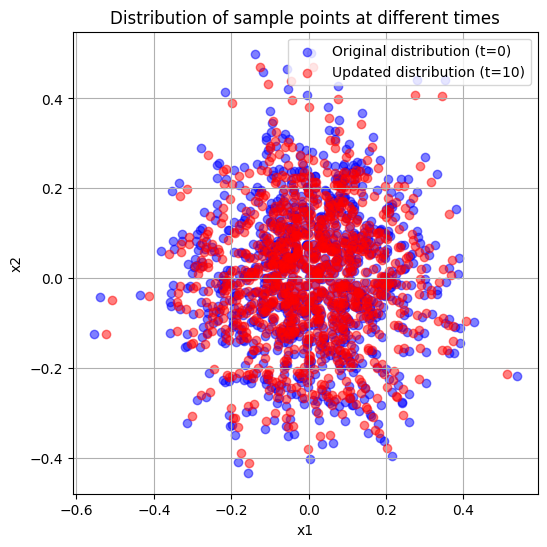

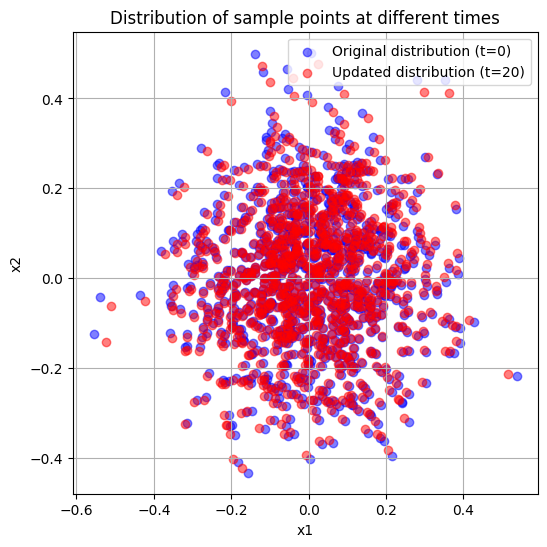

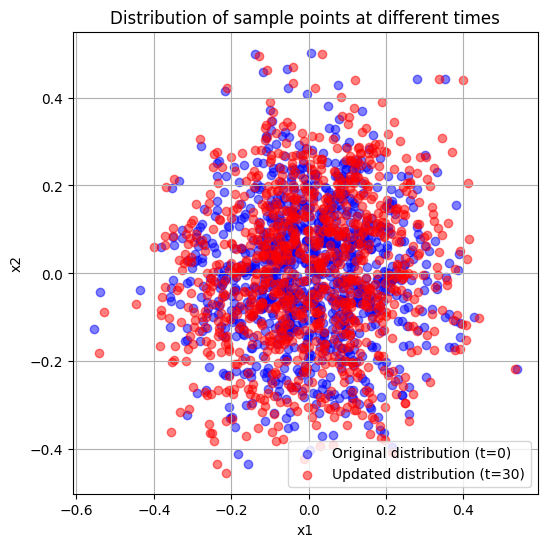

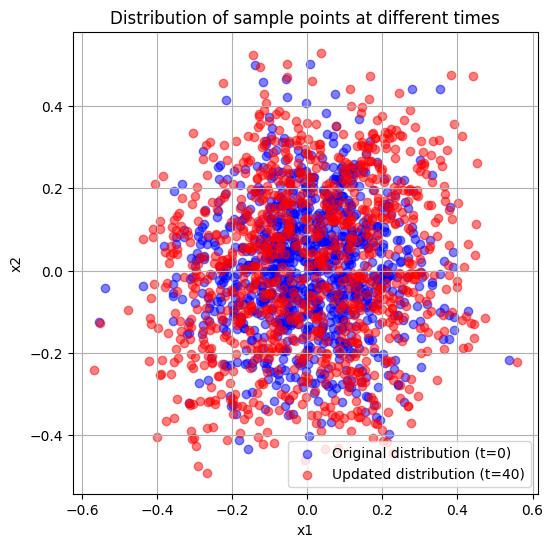

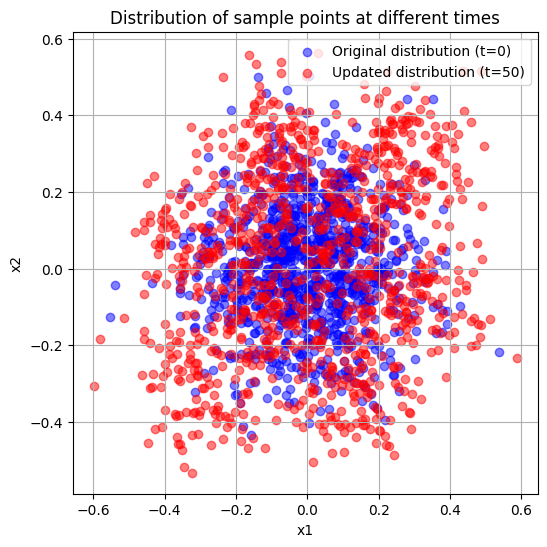

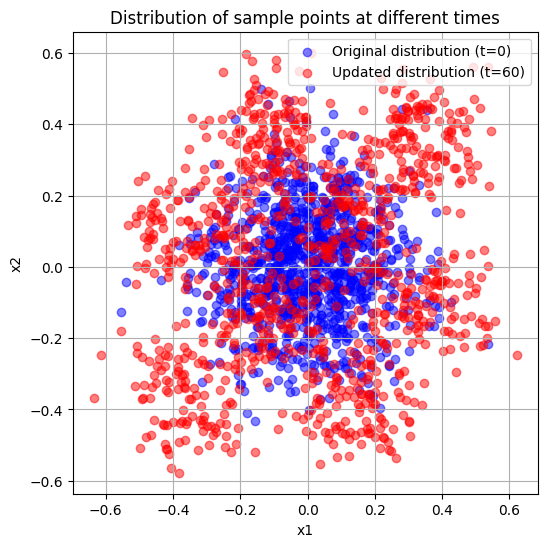

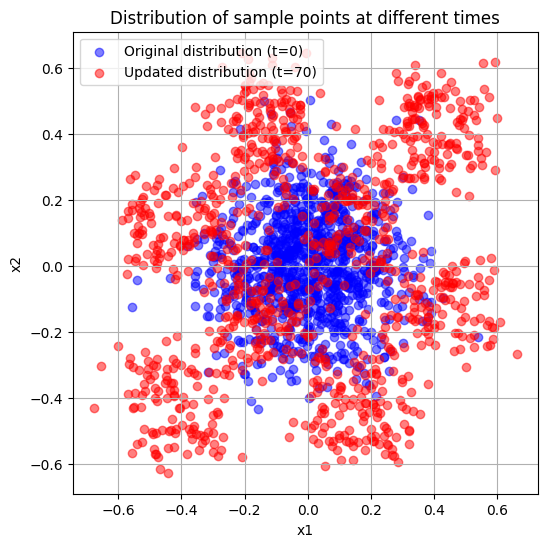

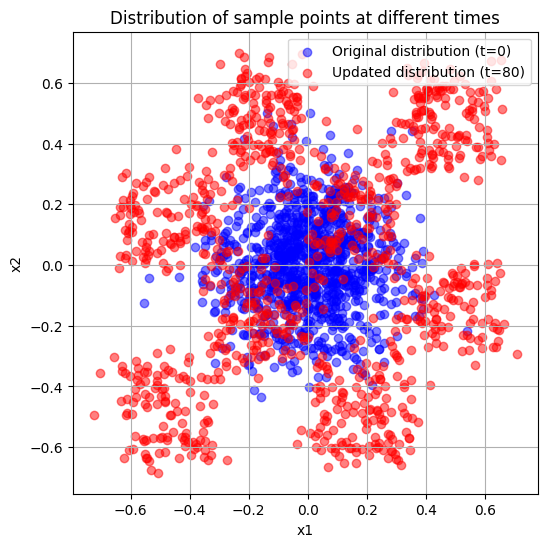

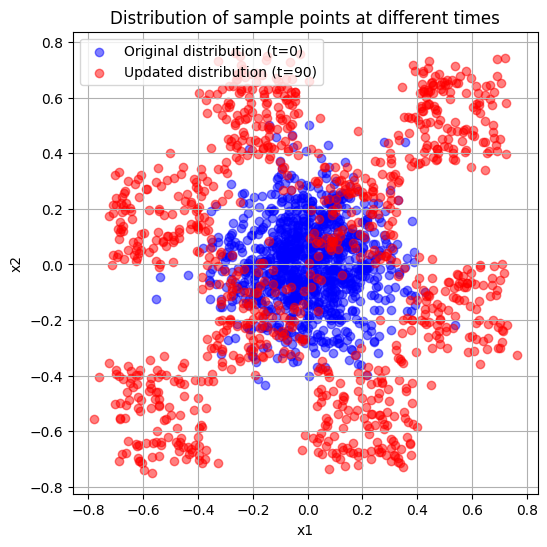

In [17]:
# TODO: run inference with the trained model. 
# Visualize the trajectory of the samples and the final samples at t=1.
# Hint: Use a simple Euler integration scheme to integrate the velocity field with 100 steps.

# We apply Euler integration as suggested, using 100 time steps between 0 and 1
t_0 = 0
t_end = 1
steps = 100
dt = (t_end - t_0)/steps

t = t_0
t_list = [t]

# We generate a new set of initial points as it was done previously
batch_size = 1000
x_t = torch.randn(batch_size, 2) * base_distribution_std
x_list = [x_t]

for i in range(steps):

    # Every step, we generate a velocity for every point to follow using the model's prediction
    t_tensor = torch.full((x_t.size(0),1), t)
    v_t = model(torch.cat([x_t, t_tensor], dim=-1))

    # We store all updated positions and their respective times
    x_t = x_t + dt*v_t
    x_list.append(x_t)

    t = t + dt
    t_list.append(t)

# We transform all tensors into arrays for visualization
for i in range(len(x_list)):
    x_list[i] = x_list[i].detach().numpy()

# Plot positions for different times.
for i in range(0, steps, 10):
    plt.figure(figsize=(6, 6))
    plt.scatter(x_list[0][:, 0], x_list[0][:, 1], color="blue", alpha=0.5, label="Original distribution (t=0)")
    plt.scatter(x_list[i][:, 0], x_list[i][:, 1], color="red", alpha=0.5, label="Updated distribution (t=" + str(i) + ")")
    plt.legend()
    plt.title("Distribution of sample points at different times")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()

# 2b

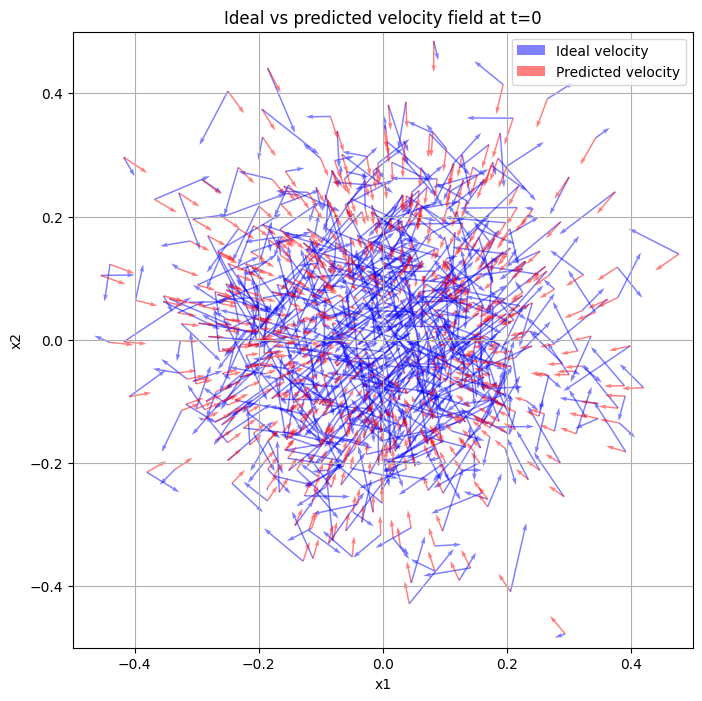

In [20]:
# We generate base and target distributions
batch_size = 1000
x_0 = torch.randn(batch_size, 2) * base_distribution_std
y_0 = generate_checkerboard_sample(num_samples=batch_size)

# We predict the velocity at t = 0 using the model
t_0 = torch.zeros(batch_size, 1)
v_0 = model(torch.cat([x_0, t_0], dim=-1))

# We take the vector that connects base and target distributions as the perfect prediction
delta_x = y_0 - x_0  # True velocity: x1 - x0

x_0 = x_0.detach().numpy()
delta_x = delta_x.detach().numpy()
v_0 = v_0.detach().numpy()

# Plot the results
plt.figure(figsize=(8, 8))
plt.quiver(
    x_0[:, 0], x_0[:, 1],  
    delta_x[:, 0], delta_x[:, 1],
    color="blue", alpha=0.5, scale=10, label="Ideal velocity"
)
plt.quiver(
    x_0[:, 0], x_0[:, 1], 
    v_0[:, 0], v_0[:, 1],
    color="red", alpha=0.5, scale=10, label="Predicted velocity"
)
plt.title("Ideal vs predicted velocity field at t=0")
plt.xlim((-0.5, 0.5))
plt.ylim((-0.5, 0.5))
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

## 3 Adversarial attacks and AI safety

In [1]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

import torch

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()
    
    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)
        
        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()
        
        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [2]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from lie_detection_utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [3]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("test_acts.shape", test_acts.shape)

# TODO: train a logistic regression probe on the train_acts and train_labels

# Train the provided model with the training data
probe = LRProbe.from_data(train_acts, train_labels)

# Evaluate the results on the test set
predictions_test = probe.pred(test_acts)
accuracy = accuracy_score(test_labels.detach().numpy(), predictions_test.detach().numpy())

print("Test Accuracy = " + str(accuracy))

c:\Users\roger\Documents\CodisHD\ML\sheet5\lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(directory, f'layer_{layer}_{i

train_acts.shape torch.Size([1196, 4096])
test_acts.shape torch.Size([300, 4096])
Test Accuracy = 0.9933333333333333


In [15]:
# TODO: optimize a perturbation on a single sample which is a lie

import numpy as np

# Find a single false statement
train_acts_numpy = train_acts.detach().numpy()
train_labels_numpy = train_labels.detach().numpy()

train_lies_numpy = train_acts[np.where(train_labels_numpy == 0)]

train_lie_numpy = train_lies_numpy[0]
train_lie = torch.tensor(train_lie_numpy)

# Define a "truth" tensor as the target
label_lie = torch.tensor(1.0)

# We reuse the optimizer chosen before in the LRProbe
opt = torch.optim.AdamW(probe.parameters(), lr=0.001, weight_decay=0.1)

# Optimization loop
num_steps = 500
for step in range(num_steps):
    # Forward pass: Compute the prediction for the perturbed sample
    output = probe(train_lie)

    # Compute the loss, a binary cross-entropy
    loss = torch.nn.BCELoss()(output, label_lie)

    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()

# Display the optimized perturbation
train_lie_pertorbed = train_lie.detach().cpu().numpy()
print("Original Lie Sample:" + str(train_lie_numpy))
print("Perturbed Sample: " + str(train_lie_pertorbed))

perturbation = train_lie - train_lie_pertorbed
print("Perturbation:", perturbation.detach().cpu().numpy())

# Check if the perturbed sample was misclassified
prediction = probe.pred(train_lie).detach().numpy()
print("Prediction = " + str(prediction))

C:\Users\roger\AppData\Local\Temp\ipykernel_10816\99558811.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lie = torch.tensor(train_lie_numpy)


Original Lie Sample:tensor([ 0.0124, -0.0027, -0.0009,  ...,  0.1840,  0.1006,  0.0673])
Perturbed Sample: [ 0.01242065 -0.00265503 -0.00090027 ...  0.18395996  0.10058594
  0.06726074]
Perturbation: [0. 0. 0. ... 0. 0. 0.]
Prediction = 1.0


In [6]:
# TODO: check whether this perturbation works on other samples too

# Convert the perturbation to a reusable format
perturbation = train_lie - torch.tensor(train_lie_numpy)

# Apply the perturbation to other samples labeled as lies
perturbed_lies = train_lies_numpy + perturbation.detach().numpy()

# Convert to tensor for evaluation
perturbed_lies_tensor = torch.tensor(perturbed_lies)

# Get predictions for all perturbed lie samples
perturbed_predictions = probe.pred(perturbed_lies_tensor)

# Check the misclassification rate
misclassified_count = (perturbed_predictions.detach().numpy() == 1).sum()  # Misclassified as truths
total_lies = perturbed_predictions.size(0)

# Display results
print(f"Number of misclassified lies: {misclassified_count}/{total_lies}")
print(f"Misclassification rate: {misclassified_count / total_lies:.2%}")

Number of misclassified lies: 593/593
Misclassification rate: 100.00%


C:\Users\roger\AppData\Local\Temp\ipykernel_10816\2461799796.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbation = train_lie - torch.tensor(train_lie_numpy)
C:\Users\roger\AppData\Local\Temp\ipykernel_10816\2461799796.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_lies_tensor = torch.tensor(perturbed_lies)


In [12]:
# TODO: add the constraint that the perturbation should be small

label_lie = torch.tensor(1.0)

# Regularization weight (higher weight for stricter constraint)
regularization_weight = 1.0

# Optimization loop
num_steps = 500
for step in range(num_steps):
    # Add the perturbation to the original lie sample
    perturbed_sample = train_lie + perturbation

    # Forward pass: Compute the prediction for the perturbed sample
    output = probe(perturbed_sample)

    # Compute the loss: Binary cross-entropy + regularization term
    classification_loss = torch.nn.BCELoss()(output, label_lie)
    perturbation_loss = regularization_weight * torch.norm(perturbation, p=2)
    loss = classification_loss + perturbation_loss

    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Clamp perturbation to a small range (optional, for additional enforcement)
    perturbation.data = torch.clamp(perturbation.data, -0.05, 0.05)

    # Print loss and perturbation norm every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}, Perturbation Norm: {torch.norm(perturbation, p=2).item()}")

# Display the optimized perturbation
print("Perturbation:", perturbation.detach().cpu().numpy())
print("Perturbed Sample:", (train_lie + perturbation).detach().cpu().numpy())

# Check if the perturbed sample is still classified correctly
prediction = probe.pred(train_lie + perturbation).detach().numpy()
print("Prediction for Perturbed Sample =", prediction)


Step 0, Loss: 0.020187605172395706, Perturbation Norm: 0.04650721326470375
Step 100, Loss: 0.003718910738825798, Perturbation Norm: 0.0013299192069098353
Step 200, Loss: 0.0027516488917171955, Perturbation Norm: 0.0004248345212545246
Step 300, Loss: 0.0028529781848192215, Perturbation Norm: 0.0004781052703037858
Step 400, Loss: 0.002882591215893626, Perturbation Norm: 0.000508507655467838
Perturbation: [ 3.7622101e-08  1.3446149e-07  3.9755673e-07 ...  2.6420653e-07
 -2.0114338e-07  1.6307159e-07]
Perturbed Sample: [ 0.01242069 -0.00265489 -0.00089987 ...  0.18396023  0.10058574
  0.06726091]
Prediction for Perturbed Sample = 1.0


According to the linear representation hypothesis, the learned logistic regression probe uses a linear decision boundary in the latent space to separate truths from lies. A small perturbation ensures that the perturbed sample stays within the correct side of the decision boundary, making misclassification unlikely.